In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.1 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=6f3e9278765910d2fa88d5842bc6e3f37a17a5b3b8cf43987533fe40d26713e3
  Stored in di

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### Download data

In [3]:
# Download Yahoo Finance data
symbol = "AAPL"  # Replace with desired stock symbol
data = yf.download(symbol, start="2010-01-01", end="2023-12-31", progress=False)

# Use 'Close' column as time series to forecast
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Volume", "Close"]].values
close_prices = df["Close"].values

#### Generate dataset for NN training

In [5]:
# Chronos Model
pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map=DEVICE, torch_dtype=torch.bfloat16)


# Sliding window to generate the dataset
def generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50):
    """ Generate dataset using Chronos for forecasting: for each covariate, predict the next day closing price.
    :param covariates: covariates data
    :param close_prices: closing prices data
    :param pipeline: Chronos model to use for forecasting
    :param window_size: Size of the sliding window
    :return: Tuple with input and output datasets (numpy arrays)
    """

    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Covariate window
        window = covariates[t:t + window_size]

        # Chronos forcasting for each covariate
        means = []
        for i in range(window.shape[1]):  # Iterate over each covariate
            context = torch.tensor(window[:, i])  # Univariate series
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predict the next day
            mean_forecast = np.mean(forecast[0].numpy())  # Distribution mean
            means.append(mean_forecast)

        # Input: Mean of covariates
        X.append(means)

        # Ground truth: Real closing price of the next day
        Y.append(close_prices[t + window_size])

    return np.array(X), np.array(Y)

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [6]:
# Generate dataset
X, Y = generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50)

# Print dataset dimensions for confirmation
print(f"Dataset X shape: {X.shape}")
print(f"Dataset Y shape: {Y.shape}")

Dataset X shape: (3472, 5)
Dataset Y shape: (3472, 1)


#### Neural Network training

In [7]:
# Normalize covariates
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

# Normalize target variable
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

# Split data into training and validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32)
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32)

# Print dimensions for confirmation
print(f"X_train shape: {X_train_split.shape}, Y_train shape: {Y_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}, Y_val shape: {Y_val_split.shape}")

X_train shape: torch.Size([2777, 5]), Y_train shape: torch.Size([2777, 1])
X_val shape: torch.Size([695, 5]), Y_val shape: torch.Size([695, 1])


#### Neural Network definition

In [8]:
class PricePredictionNN(nn.Module):
    """
    Neural Network for price prediction.
    Architecture: 3 fully connected layers with ReLU activation and dropout.
    """

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(PricePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

#### Neural Network training

In [9]:
# Hyperparameters
LR = 0.001  # Initial learning rate
WEIGHT_DECAY = 4e-5  # Regularization
STEP_SIZE = [150, 300, 600]  # Number of epochs before decreasing LR
GAMMA = 0.1  # Multiplicative factor for learning rate step-down

Epoch 0/1000 (LR=0.001), Training Loss: 0.0748, Validation Loss: 0.0020
Epoch 1/1000 (LR=0.001), Training Loss: 0.0016, Validation Loss: 0.0010
Epoch 2/1000 (LR=0.001), Training Loss: 0.0012, Validation Loss: 0.0009
Epoch 3/1000 (LR=0.001), Training Loss: 0.0011, Validation Loss: 0.0008
Epoch 4/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 5/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0009
Epoch 6/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0009
Epoch 7/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 8/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 9/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Training stopped at epoch 10 because training loss < 0.001


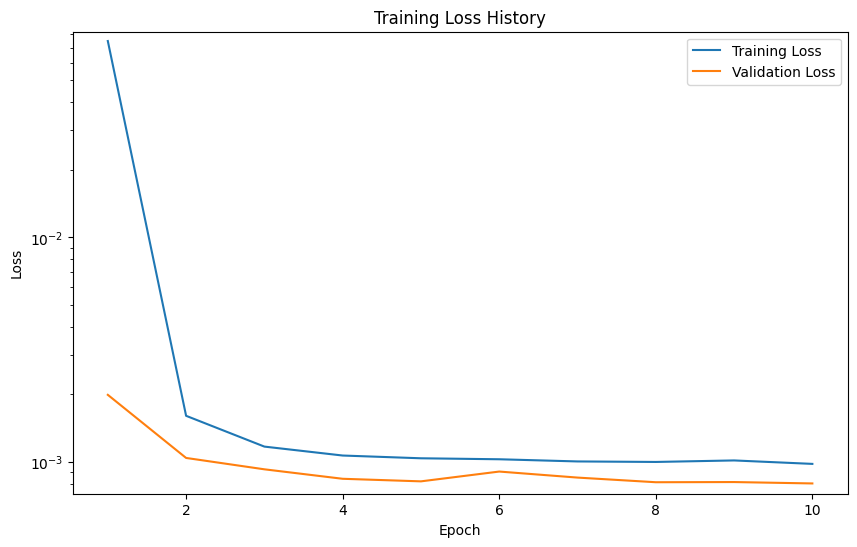

In [98]:
# Model creation
input_size = X.shape[1]  # Feature number
hidden_size_1 = 128  # Number of hidden units in first hidden layer
hidden_size_2 = 64  # Number of hidden units in second hidden layer
output_size = 1  # Output size (1 for regression)
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
criterion = nn.MSELoss()  # Mean Squared Error because it's a regression problem
scheduler = MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

# Create DataLoader for training
batch_size = 32
train_dataset = TensorDataset(X_train_split, Y_train_split)
val_dataset = TensorDataset(X_val_split, Y_val_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping
best_loss = float("inf")
patience = 100  # Maximum number of epochs without improvement
patience_counter = 0

loss_history = []
loss_history_val = []

# Initialize training
num_epochs = 1000
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0

    # Training loop
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average loss per batch
    loss_history.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions_list = []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            val_predictions = model(batch_X)
            val_predictions_list.append(val_predictions.numpy())  # Save predictions

            loss = criterion(val_predictions, batch_Y)
            val_loss += loss.item()

    # Convert the list to a numpy array
    val_predictions = np.concatenate(val_predictions_list, axis=0)

    # Convert back to original scale
    val_predictions_original = scaler_y.inverse_transform(val_predictions)

    val_loss /= len(val_loader)  # Average loss per batch
    loss_history_val.append(val_loss)

    # Learning rate scheduler step
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} (LR={current_lr}), Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "nn_model.pth")  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Interrupt training if loss drops below 0.001 (early stopping)
    if train_loss < 0.001:
        print(f"Training stopped at epoch {epoch + 1} because training loss < 0.001")
        break

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
plt.plot(range(1, len(loss_history_val) + 1), loss_history_val, label="Validation Loss")
plt.yscale("log")  # Use log scale to better see the loss decrease
plt.ylim([min(loss_history_val + loss_history) * 0.9, max(loss_history) * 1.1])  # Auto-adjust Y scale
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

In [167]:
# Save the model
torch.save(model.state_dict(), "nn_model.pth")

# Load the model
# model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-185-be28856877ab>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("nn_model.pth"))


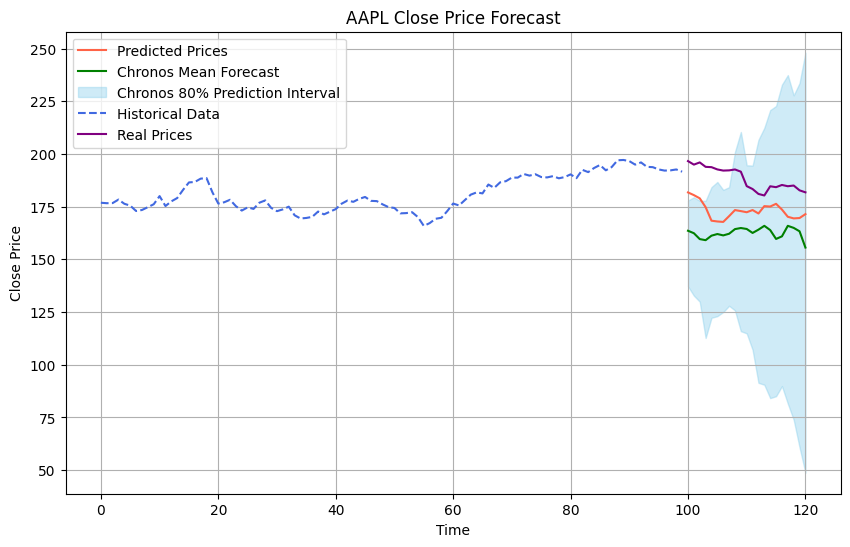

In [185]:
# Test on new data (from 2024), plotting the true value,
# the value predicted by our NN and the value (+confidence interval) predicted by Chronos, to compare them.
# Ensure that the vectors plotted are of the correct dimensions

# New data
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
#new_covariates = new_data[["Open", "High", "Low", "Volume", "Close"]].values
#new_close_prices = new_data["Close"].values

# Define the number of days in the time window
window_size = 10  # Same as the one used for training

# Extend test data including the last `window_size` days of training
extended_new_data = pd.concat([df.iloc[-window_size:], new_data])  # Join the last window_size days of training with the new data

# Extract covariates and close prices
new_covariates = extended_new_data[["Open", "High", "Low", "Volume", "Close"]].values
new_close_prices = extended_new_data["Close"].values

# Generate test data with sliding window
X_test, Y_test = generate_dataset_with_chronos(new_covariates, new_close_prices, pipeline)
X_test = scaler_x.transform(X_test)

# Convert to PyTorch tensor
X_test = torch.tensor(X_test, dtype=torch.float32)

model.load_state_dict(torch.load("nn_model.pth"))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

test_predictions = scaler_y.inverse_transform(test_predictions)

# Data index for plotting historical and test data
historical_index = np.arange(len(close_prices[-100:]))  # Historical data
test_index = np.arange(len(close_prices[-100:]), len(close_prices[-100:]) + len(test_predictions))

# Reduce context and prediction length for Chronos
chronos_context = torch.tensor(close_prices[-100:])  # Use the last 100 days for context
chronos_prediction_length = len(test_predictions)

chronos_forecast = pipeline.predict(context=chronos_context, prediction_length=chronos_prediction_length)
low, median, high = np.quantile(chronos_forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(chronos_forecast[0].numpy(), axis=0)

# Ensure vectors have the correct dimensions
mean_forecast = mean_forecast[:len(test_predictions)]
low = low[:len(test_predictions)]
high = high[:len(test_predictions)]

# Plot the forecast
plt.figure(figsize=(10, 6))

plt.plot(test_index, test_predictions, color="tomato", label="Predicted Prices")  # NN predictions
plt.plot(test_index, mean_forecast, color="green", label="Chronos Mean Forecast")  # Chronos
plt.fill_between(test_index, low, high, color="skyblue", alpha=0.4, label="Chronos 80% Prediction Interval")  # Chronos confidence

# Plot the history, only last 100 days
plt.plot(historical_index[-100:], close_prices[-100:], color="royalblue", label="Historical Data", linestyle='--')  # Historical data

# Plot the "real" line
plt.plot(test_index, new_close_prices[:len(test_predictions)], color="purple", label="Real Prices")  # Real data, only for the test period

plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [186]:
from scipy.stats import gmean

# Evaluation metrics
def mase(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE)
    y_true: true values
    y_pred: predicted values
    y_train: historical series to calculate the naive benchmark
    """

    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive Model: mean differences between successive values
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast


def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

# Compute metrics
results = {}
results['Neural Network'] = compute_metrics(new_close_prices[:len(test_predictions)], test_predictions, close_prices[-100:].reshape(-1))
results['Chronos'] = compute_metrics(new_close_prices[:len(mean_forecast)], mean_forecast, close_prices[-100:].reshape(-1))
results = pd.DataFrame(results).T

print("PERFORMANCE METRICS:")
print(results)

# Compute relative performance
relative_scores = agg_relative_score(results.loc['Neural Network'], results.loc['Chronos'])
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

PERFORMANCE METRICS:
                       MSE       RMSE       MAPE       MASE
Neural Network  262.643352  16.206275   8.010781   9.231151
Chronos         706.636916  26.582643  13.650970  15.696299
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.371681
RMSE    0.609656
MAPE    0.586829
MASE    0.588110
dtype: float64


<ipython-input-186-d82d98ac4ae7>:26: FutureWarning: using <function gmean at 0x7d8c42f1a340> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements
